In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
%run -i Trajectory_Optimization.py Zero-east-settings.json

/home/hayasakaist/Trajectory_Optimization/coordinate.py:256: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))
  if u.dot(normalize(pos_eci)) > 0.999999:
/home/hayasakaist/Trajectory_Optimization/coordinate.py:282: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  inclination_rad = acos(c1_eci.dot(np.array([0.0,0.0,1.0])))
/home/hayasakaist/Trajectory_Optimization/coordinate.py:287: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  argument_perigee = acos(n_eci.dot(normalize(f_eci)))
/home/hayasakaist/Trajectory_Optimization/optimization6DoFquat.py:583: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  lh = D.dot(x / unit_x)
/home/hayasakaist/Trajectory_Optimization/optimization6DoFquat.py:604

6578.137

List of user-set options:

                                    Name   Value                used
                        file_print_level = 5                     yes
                   hessian_approximation = limited-memory        yes
                           linear_solver = pardisomkl            yes
                                max_iter = 500                   yes
                             output_file = Zero-east_2022-03-25-182425_pyIPOPT.out  yes
                             print_level = 3                     yes
                 print_timing_statistics = yes                   yes
                      print_user_options = yes                   yes
                                      sb = yes                   yes
                                     tol = 1e-10                 yes
Total number of variables............................:     1097
                     variables with only lower bounds:        0
                variables with lower and upper bounds:   

In [1]:
display_6DoF(out)

NameError: name 'display_6DoF' is not defined

In [39]:
out.loc[:,["time","heading","pitch","roll"]].to_csv("../RocketSim/bin/input/OptResult-Attitude.csv",index=None)

In [40]:
ref = pd.read_csv("ALMA/ZERO_NOMINAL_2201.csv",skiprows=[0,1,2])

In [41]:
df = pd.read_csv("../RocketSim/bin/output/OptResult-out.csv")

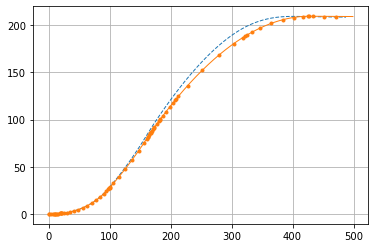

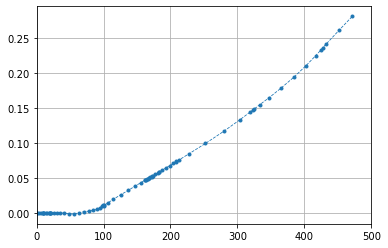

In [42]:
plt.plot(ref["time"],ref["h"],"--",lw=1)
plt.plot(out["time"],out["alt"],".")
plt.plot(df["time"],df["alt"],c="C1",lw=1)
plt.grid()

df1  = np.interp(out["time"], df["time"], df["alt"])
plt.figure()
plt.plot(out["time"], df1-out["alt"], ".--", lw=0.8)
plt.xlim([0,500])
plt.grid()

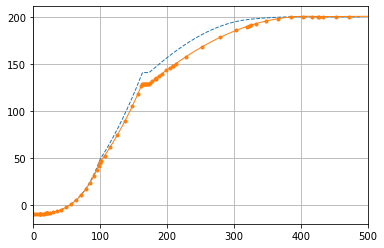

In [43]:
plt.plot(ref["time"], ref["ha"], "--",lw=1)
plt.plot(out["time"], out["ha"],".")
plt.plot(df["time"], df["ha"],c="C1",lw=1)
plt.xlim([0,500])
plt.ylim([-20,None])
plt.grid()


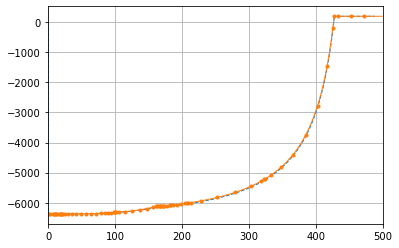

In [44]:
plt.plot(ref["time"], ref["hp"], "--",lw=1)
plt.plot(out["time"], out["hp"],".")
plt.plot(df["time"], df["hp"],c="C1",lw=1)
plt.xlim([0,500])
plt.grid()


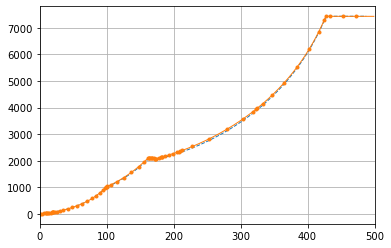

In [45]:
plt.plot(ref["time"],ref["vr"],"--",lw=1)
plt.plot(out["time"],out["vr"],".")
plt.plot(df["time"],df["vel_ground"],c="C1",lw=1)
plt.xlim([0,500])
plt.grid()


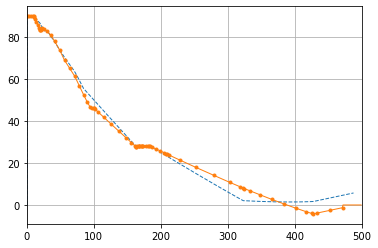

In [46]:
plt.plot(ref["time"],ref["eularGDB[1]"],"--",lw=1)
plt.plot(out["time"],out["pitch"],".")
plt.plot(df["time"],df["pitch"].to_numpy('f8'),c="C1",lw=1)
plt.xlim([0,500])
plt.grid()


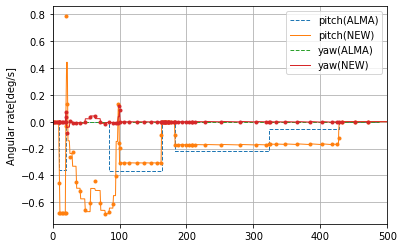

In [47]:
plt.plot(ref["time"],ref["Q"],"--",lw=1,label="pitch(ALMA)")
plt.plot(out["time"],out["rate_Q"],".")
plt.plot(df["time"],df["rate_Q"]*180/np.pi,c="C1",lw=1,label="pitch(NEW)")
plt.plot(ref["time"],ref["R"],"--",lw=1,label="yaw(ALMA)")
plt.plot(out["time"],out["rate_R"],".")
plt.plot(df["time"],df["rate_R"]*180/np.pi,c="C3",lw=1,label="yaw(NEW)")

plt.xlim([0,500])
plt.ylabel("Angular rate[deg/s]")
plt.legend()
plt.grid()

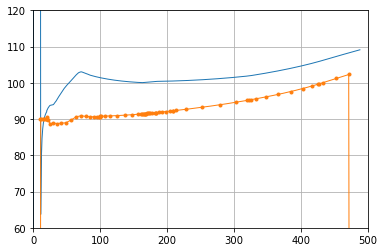

In [48]:
plt.plot(ref["time"],ref["eularGDB[2]"],lw=1)
plt.plot(out["time"],out["heading"],".")
plt.plot(df["time"],df["heading"].to_numpy('f8'),c="C1",lw=1)
plt.xlim([0,500])
plt.ylim([60,120])
plt.grid()

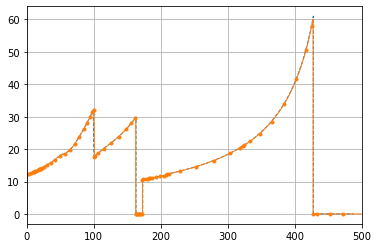

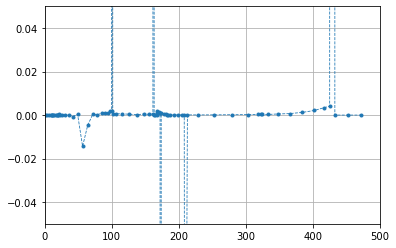

In [49]:
plt.plot(ref["time"],ref["axb"],"--",lw=1)
plt.plot(out["time"],out["accel_X"],".")
plt.plot(df["time"],df["acc_BODY_X"],c="C1",lw=1)
plt.xlim([0,500])
plt.grid()

df1  = np.interp(out["time"], df["time"], df["acc_BODY_X"])
plt.figure()
plt.plot(out["time"], df1-out["accel_X"], ".--", lw=0.8)
plt.xlim([0,500])
plt.ylim([-0.05,0.05])
plt.grid()

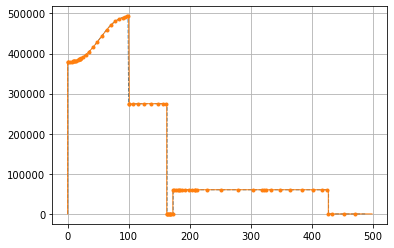

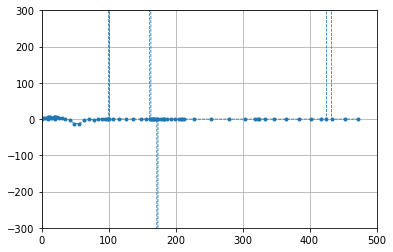

In [50]:
plt.plot(ref["time"],ref["Fr"],"--",lw=1)
plt.plot(out["time"],out["thrust"],".")
plt.plot(df["time"],df["thrust"],c="C1",lw=1)
plt.grid()

df1  = np.interp(out["time"], df["time"], df["thrust"])
plt.figure()
plt.plot(out["time"], df1-out["thrust"], ".--", lw=0.8)
plt.xlim([0,500])
plt.ylim([-300,300])
plt.grid()

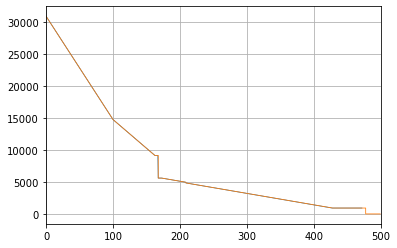

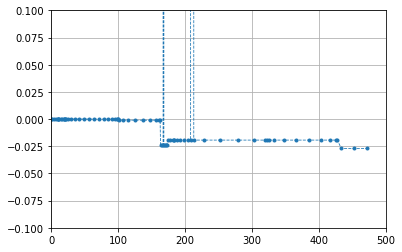

In [51]:
#plt.plot(ref["time"],ref["weight"])
plt.plot(out["time"],out["mass"],lw=0.8)
plt.plot(df["time"],df["total mass"],lw=0.8)
plt.xlim([0,500])
plt.grid()

df1  = np.interp(out["time"], df["time"], df["total mass"])
plt.figure()
plt.plot(out["time"], df1-out["mass"], ".--", lw=0.8)
plt.xlim([0,500])
plt.ylim([-0.1,0.1])
plt.grid()

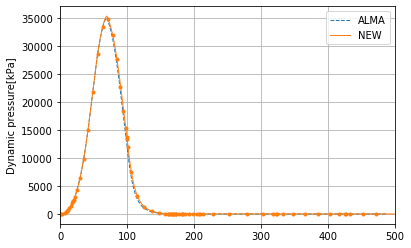

In [52]:
plt.plot(ref["time"],ref["q"],"--",lw=1,label="ALMA")
plt.plot(out["time"],out["q"],".")
plt.plot(df["time"],df["q"],c="C1",lw=1,label="NEW")
plt.xlim([0,500])
plt.ylabel("Dynamic pressure[kPa]")
plt.legend()
plt.grid()

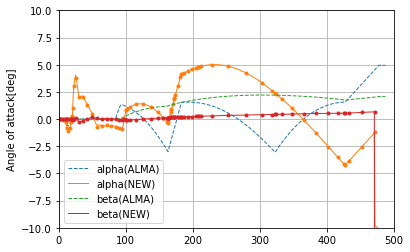

In [53]:
plt.plot(ref["time"],ref["alpha"],"--",lw=1,label="alpha(ALMA)")
plt.plot(out["time"],out["aoa_alpha"],".")
plt.plot(df["time"],df["aoa_alpha"],c="C1",lw=1,label="alpha(NEW)")
plt.plot(ref["time"],ref["beta"],"--",lw=1,label="beta(ALMA)")
plt.plot(out["time"],out["aoa_beta"],".")
plt.plot(df["time"],df["aoa_beta"],c="C3",lw=1,label="beta(NEW)")

plt.xlim([0,500])
plt.ylim([-10,10])
plt.legend()
plt.ylabel("Angle of attack[deg]")
plt.grid()

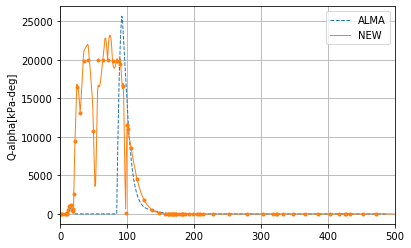

In [54]:
plt.plot(ref["time"],ref["alphaq"],"--",lw=1,label="ALMA")
plt.plot(out["time"],out["q"]*out["aoa_total"],".")
plt.plot(df["time"],df["q"]*df["aoa_total"],c="C1",lw=1,label="NEW")
plt.xlim([0,500])
plt.ylabel("Q-alpha[kPa-deg]")
plt.legend()
plt.grid()